In [1]:
!nvidia-smi

Sat Apr 24 11:45:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00199803days (172.63sec)


In [3]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

Cloning into 'custom_ImageNet'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 61 (delta 21), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), done.


In [4]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [5]:
import sys
sys.path.append('/content/custom_ImageNet')

In [19]:
import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset
from utils.seed_everything import seed_everything

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [8]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import datetime

!pip install tensorboardX
import tensorboardX as tbx
from tensorboardX import SummaryWriter


     |████████████████████████████████| 122kB 13.0MB/s 


In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!cp "drive/My Drive/ImageNet/retina_20random_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/retina_original_ImagenetTest.zip" /content/

In [12]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [13]:
!7z x retina_20random_ImagenetTrain.zip
!mv "content/retina_ImagenetTrain" ../content/
!7z x retina_original_ImagenetTest.zip
!mv "content/retina_ImagenetTest" ../content/

Output hidden; open in https://colab.research.google.com to view.

In [14]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [15]:
def make_path_list_png(rootpath):
    """
    To create the list of file path about Image data and annotation data
    for training and test

    Inputs
    --------------------
    rootpath : str
        path data for data folder

    Returns
    --------------------
    *_img_list, *_anno_list
        list of path for each data
    """

    img_list = glob.glob(rootpath+'*/*.png')

    return img_list

In [16]:
rootpathTrain ='retina_ImagenetTrain/'
rootpathTest ='retina_ImagenetTest/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [17]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [20]:
# random seed fixed func from github
seed_everything(123)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
classes_list = train_dataset.get_label_relation()

batch_size = 32

In [21]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [22]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [23]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

283136

In [24]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


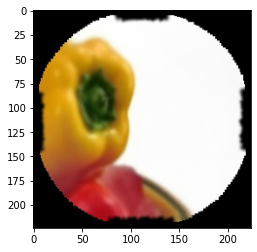

In [25]:
index = 102345
imges, label = train_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [26]:
label

3

In [27]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [28]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [29]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

In [30]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):
    
    log_path = F"/content/drive/My Drive/Colab Notebooks/Log/"
    now = datetime.datetime.now()
    folder = F"{name}"+now.strftime('%Y%m%d_%H%M%S')

    writer = tbx.SummaryWriter(log_path+folder)

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats;
    train_loss=0; val_loss=0; train_acc=0; val_acc=0; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_acc = 0       # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        #if(LOAD_STATE==True)and(epoch==epochs+1):
                        #    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_acc += preds.eq(labels.view_as(preds)).sum().item()

            #print(epoch_acc)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_acc / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_loss=epoch_loss; train_acc=epoch_acc;
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_loss=epoch_loss; val_acc=epoch_acc;

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    total_name = name+".tar"
                    path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if (epoch%4==0)or(epoch%10==0):
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
            
        print('-------------')
        writer.add_scalars('/loss', {'train_loss': train_loss,
                                     'val_loss': val_loss
                                    }, epoch)
      
        writer.add_scalars('/acc', {'train_acc': train_acc,
                                    'val_acc': val_acc
                                    }, epoch)

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

In [31]:
class TinyCNN(nn.Module):
    """
    TinyCNN: https://arxiv.org/abs/1911.06777v1

    fc1, fc2 should be modified for each image size and class num.

    model=TinyCNN()
    model.fc1 = nn.Linear(in_features=128 * FC_H * FC_W, out_features=N_CLASSES)
    model.fc2 = nn.Linear(in_features=100, out_features=N_CLASSES)
    """

    def __init__(self, DROPOUT=False):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   32,  3, 1, 1, bias=False)
        self.conv2 = nn.Conv2d(32,  64,  3, 1, 1, bias=False)
        self.conv3 = nn.Conv2d(64,  128, 3, 1, 1, bias=False)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1, bias=False)

        self.relu = nn.ReLU(inplace=False)
        self.pool = nn.MaxPool2d(2)
        
        self.classifier = nn.Sequential(nn.Linear(128 * 14 * 14, 100), nn.Dropout2d(p=0.5), self.relu,
                                  nn.Linear(100, 20), nn.Dropout2d(p=0.4))
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant(m.bias, 0)

    def encode(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        return x

    def forward(self, x):
        x = self.encode(x)

        x = x.view(x.size(0),-1)
        x = self.classifier(x)

        return self.relu(x)

### CONST data

In [32]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 2
else:
    NUM_EPOCS = 30

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Model preparation

### Loss function

In [33]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Model preparation

In [34]:
# TinyCNN model instance set
model=TinyCNN()

# FC layer input&output size change
#model.fc1 = nn.Linear(in_features=128 * FC_H * FC_W, out_features=100)
#model.fc2 = nn.Linear(in_features=100, out_features=N_CLASSES)

model.cuda()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


TinyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=100, bias=True)
    (1): Dropout2d(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=20, bias=True)
    (4): Dropout2d(p=0.4, inplace=False)
  )
)

In [35]:
# Optimization setting
optimizer = optim.SGD(model.parameters(), lr=0.007, momentum=0.9)

In [36]:
LOAD_STATE = False
EPOCH = 40             # This values need to check the latest tar ffile name with epoch.
name = "06_mple"
parent_folder = "Retina_image"
folder_name = "simple"

if LOAD_STATE:
    stats=[];
    
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/{parent_folder}/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    use_pretrained = True
    best_model = models.mobilenet_v2()
    best_model.classifier[1] = nn.Linear(in_features=1280, out_features=N_CLASSES)
    best_model.cuda()
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/{parent_folder}/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=model;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [37]:
best_model, stats = train_model(model, dataloaders_dict, criterion, optimizer, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/30
-------------



train Loss: 0.0876 Acc: 17.2083



val Loss: 0.0794 Acc: 28.3581
-------------
Epoch 2/30
-------------



train Loss: 0.0836 Acc: 22.0364



val Loss: 0.0762 Acc: 35.5758
-------------
Epoch 3/30
-------------



train Loss: 0.0808 Acc: 25.6078



val Loss: 0.0728 Acc: 38.7913
-------------
Epoch 4/30
-------------



train Loss: 0.0787 Acc: 27.9639



val Loss: 0.0698 Acc: 41.5602
-------------
Epoch 5/30
-------------



train Loss: 0.0770 Acc: 29.7938



val Loss: 0.0661 Acc: 45.9638
-------------
Epoch 6/30
-------------



train Loss: 0.0758 Acc: 31.0286



val Loss: 0.0665 Acc: 46.6193
-------------
Epoch 7/30
-------------



train Loss: 0.0747 Acc: 32.1422



val Loss: 0.0655 Acc: 46.6970
-------------
Epoch 8/30
-------------



train Loss: 0.0740 Acc: 32.9534



val Loss: 0.0643 Acc: 48.5929
-------------
Epoch 9/30
-------------



train Loss: 0.0733 Acc: 33.5877



val Loss: 0.0653 Acc: 48.0857
-------------
Epoch 10/30
-------------



train Loss: 0.0728 Acc: 34.0578



val Loss: 0.0640 Acc: 49.6694
-------------
Epoch 11/30
-------------



train Loss: 0.0726 Acc: 34.2620



val Loss: 0.0634 Acc: 50.2147
-------------
Epoch 12/30
-------------



train Loss: 0.0721 Acc: 34.7374



val Loss: 0.0627 Acc: 50.1596
-------------
Epoch 13/30
-------------



train Loss: 0.0720 Acc: 34.8977



val Loss: 0.0644 Acc: 48.6706
-------------
Epoch 14/30
-------------



train Loss: 0.0719 Acc: 34.9903



val Loss: 0.0636 Acc: 49.2625
-------------
Epoch 15/30
-------------



train Loss: 0.0716 Acc: 35.1386



val Loss: 0.0615 Acc: 51.2305
-------------
Epoch 16/30
-------------



train Loss: 0.0716 Acc: 35.2431



val Loss: 0.0634 Acc: 49.9195
-------------
Epoch 17/30
-------------



train Loss: 0.0714 Acc: 35.3954



val Loss: 0.0618 Acc: 51.4410
-------------
Epoch 18/30
-------------



train Loss: 0.0712 Acc: 35.6232



val Loss: 0.0614 Acc: 51.3435
-------------
Epoch 19/30
-------------



train Loss: 0.0712 Acc: 35.6175



val Loss: 0.0643 Acc: 48.0659
-------------
Epoch 20/30
-------------



train Loss: 0.0711 Acc: 35.6867



val Loss: 0.0614 Acc: 50.7516
-------------
Epoch 21/30
-------------



train Loss: 0.0711 Acc: 35.8104



val Loss: 0.0643 Acc: 49.6482
-------------
Epoch 22/30
-------------



train Loss: 0.0710 Acc: 35.9368



val Loss: 0.0629 Acc: 49.1015
-------------
Epoch 23/30
-------------



train Loss: 0.0711 Acc: 35.8005



val Loss: 0.0620 Acc: 50.7403
-------------
Epoch 24/30
-------------



train Loss: 0.0710 Acc: 35.9054



val Loss: 0.0619 Acc: 49.8601
-------------
Epoch 25/30
-------------



train Loss: 0.0710 Acc: 36.0032



val Loss: 0.0624 Acc: 50.4916
-------------
Epoch 26/30
-------------



train Loss: 0.0711 Acc: 35.9530



val Loss: 0.0605 Acc: 52.6178
-------------
Epoch 27/30
-------------



train Loss: 0.0711 Acc: 35.9064



val Loss: 0.0611 Acc: 50.8335
-------------
Epoch 28/30
-------------



train Loss: 0.0713 Acc: 35.6899



val Loss: 0.0611 Acc: 52.2449
-------------
Epoch 29/30
-------------



train Loss: 0.0715 Acc: 35.5903



val Loss: 0.0635 Acc: 49.1707
-------------
Epoch 30/30
-------------



train Loss: 0.0715 Acc: 35.5366



val Loss: 0.0633 Acc: 49.9082
-------------
Lowest training loss 0.07097017470828071
Lowest validation loss 0.06049525907354102
Highest training accuracy 36.0031928119349
Highest validation accuracy 52.61782323688969
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/06_mple_Loss _.png06_mple_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/06_mple_Accuracy _.png06_mple_Accuracy _.png


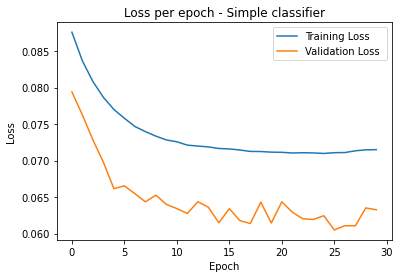

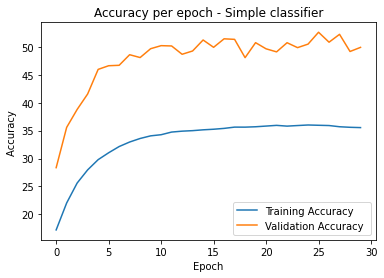

In [38]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats[0],stats[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats[1],stats[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 2.1430 
Testing Accuracy: 914/2000 (45.70%)
apple Class Accuracy: 28/100 (28.00%)
banana Class Accuracy: 59/100 (59.00%)
bear Class Accuracy: 64/100 (64.00%)
bell_pepper Class Accuracy: 43/100 (43.00%)
bird Class Accuracy: 48/100 (48.00%)
broccoli Class Accuracy: 65/100 (65.00%)
cat Class Accuracy: 25/100 (25.00%)
cauliflower Class Accuracy: 44/100 (44.00%)
cow Class Accuracy: 82/100 (82.00%)
dog Class Accuracy: 28/100 (28.00%)
elephant Class Accuracy: 63/100 (63.00%)
fox Class Accuracy: 37/100 (37.00%)
goat Class Accuracy: 12/100 (12.00%)
horse Class Accuracy: 52/100 (52.00%)
mashed_potato Class Accuracy: 49/100 (49.00%)
orange Class Accuracy: 52/100 (52.00%)
pineapple Class Accuracy: 51/100 (51.00%)
pomegranate Class Accuracy: 54/100 (54.00%)
tomato Class Accuracy: 58/100 (58.00%)
zebra Class Accuracy: 0/100 (0.00%)
Classifier has Acc=0.457 P=0.457 R=0.450 F1=0.442


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        apple       0.21      0.28      0.24       100
       banana       0.55      0.59      0.57       100
         bear       0.59      0.64      0.62       100
  bell_pepper       0.46      0.43      0.44       100
         bird       0.33      0.48      0.39       100
     broccoli       0.60      0.65      0.62       100
          cat       0.41      0.25      0.31       100
  cauliflower       0.60      0.44      0.51       100
          cow       0.40      0.82      0.54       100
          dog       0.25      0.28      0.26       100
     elephant       0.37      0.63      0.46       100
          fox       0.60      0.37      0.46       100
         goat       0.27      0.12      0.17       100
        horse       0.46      0.52      0.49       100
mashed_potato       0.45      0.49      0.47       100
       orange       0.60      0.52      0.56       100
    pineapple       0.65      0.51      0.57       100
  pomegra

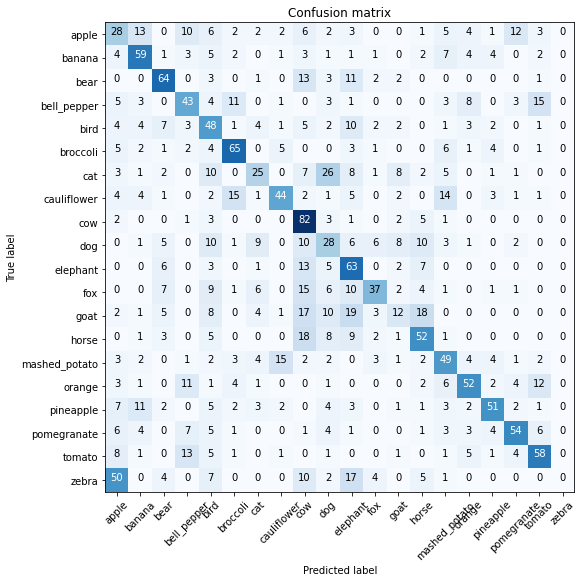

In [39]:
result = test_model(best_model,criterion, name)